In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate,ConvLSTM2D
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D
from keras import initializers
from keras.initializers import RandomNormal
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [2]:
# Define paths
config = dotenv_values(".env")
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']


In [3]:
# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_VAL = '2014'
YY_TEST = [2016, 2020]
sel_levels = [500, 850, 1000]
G = 9.80665 

# define coordinates (for now use the same for the ppredictors and target)
LATS = [80,33]
LONS = [-38,25]

## Data loading

In [4]:
# Read data
# Precipitation ERA5
pr = get_era5_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS, LATS)
# I will crop lon and lat
lon_pr=pr.lon
lat_pr=pr.lat
pr_Datarray = xr.DataArray(pr.tp) # to make the format as pr95
# Define precipitation extremes using the 95th
th95 = 0.95
pr95 = precip_exceedance_xarray(pr, th95)

Extracting data for the period 1979-01-01 - 2020-12-31


In [5]:
## Get the date with the max number of grid with pr>95th

In [6]:
x=pr95.sum(dim=['lat','lon'])

In [7]:
dd = x.max('time')

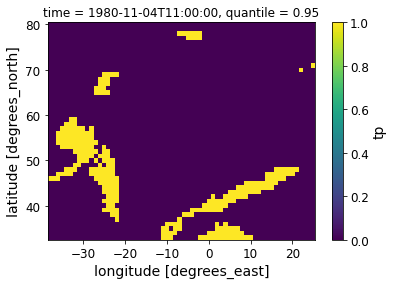

In [8]:
pr95[dd,:,:].plot()

<AxesSubplot:title={'center':'time = 1980-11-04T11:00:00, quantile = 0.95'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

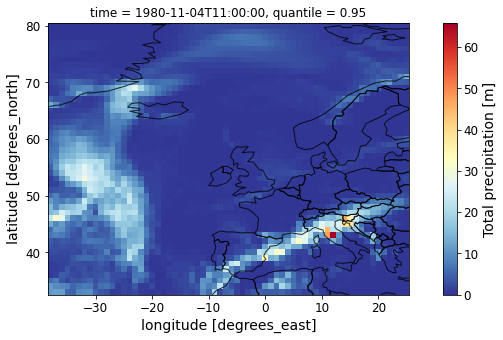

In [9]:
# Load country outlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, axs = plt.subplots(1, 1,figsize=(12,5))
pr_Datarray[dd,:,:].plot(cmap=mpl.cm.RdYlBu_r)
world.plot(ax = axs, alpha = 0.8, facecolor = 'none', lw = 1)


In [10]:
# Read covariates: RH, T2m, geopotential, wind (1x1deg)
z = get_era5_data(PATH_ERA5 + '/geopotential/grid1/*.nc', DATE_START, DATE_END, LONS, LATS)
z = z.sel(level=sel_levels)
# Get Z in geopotential height (m)
z.z.values = z.z.values/G
# select the same coordinates values than precipitation
#z_new = z.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [11]:
# temperature
t2m = get_era5_data(PATH_ERA5 + '/temperature/grid1/Grid1_Daymean_era5_T2M_EU_19790101-20211231.nc', DATE_START, DATE_END, LONS, LATS)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)
# select the same coordinates values than precipitation
#t2m_new = t2m.sel(lon=slice(min(lon_pr), max(lon_pr)))
#t2m_1lev = t2m_new.expand_dims('level', axis=1)

Extracting data for the period 1979-01-01 - 2020-12-31


In [12]:
# relative humidity
rh = get_era5_data(PATH_ERA5 + '/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END,LONS, LATS)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date) # need to have the same time-format
rh = rh.sel(level=sel_levels)
#rh_new = rh.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [13]:
# Wind components 850hpa
u850 = get_era5_data(PATH_ERA5 + '/U_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS, LATS)
u850['time'] = pd.DatetimeIndex(u850.time.dt.date)
#u850_new = u850.sel(lon=slice(min(lon_pr), max(lon_pr)))
v850 = get_era5_data(PATH_ERA5 + '/V_wind/day_grid1/*.nc', DATE_START, DATE_END,LONS, LATS)
v850['time'] = pd.DatetimeIndex(v850.time.dt.date)
#v850_new = v850.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [14]:
tot_water = get_era5_data(PATH_ERA5 + '/total_column_water/day_grid1/*.nc', DATE_START, DATE_END,LONS, LATS)
tot_water['time'] = pd.DatetimeIndex(tot_water.time.dt.date)
#tot_water_new = tot_water.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31


In [15]:
# checking dimensions
print('dimension of z',z.dims)
print('dimension of t2m:',t2m.dims)
print('dimension of rh:',rh.dims)
print('dimension of u:',u850.dims)
print('dimension of pr:',pr.dims)
print('dimension of tw:',tot_water.dims)

dimension of z Frozen({'time': 15341, 'lon': 64, 'lat': 48, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 64, 'lat': 48})
dimension of rh: Frozen({'time': 15341, 'lon': 64, 'lat': 48, 'level': 3})
dimension of u: Frozen({'time': 15341, 'lon': 64, 'lat': 48})
dimension of pr: Frozen({'time': 15341, 'lon': 64, 'lat': 48})
dimension of tw: Frozen({'time': 15341, 'lon': 64, 'lat': 48})


In [16]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = {
     'z': sel_levels,
      'T2MMEAN': None,
      'r': sel_levels,
      'u': None,
      'v': None,
      'tcwv':None}

In [17]:
# Data preparation
# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t2m, rh, u850, v850, tot_water]
#datasets = [z_new, tot_water_new]

In [18]:
# Check if all have the same latitude order
for idat in range(0, len(datasets)):
    # Invert lat axis if needed
    if datasets[idat].lat[0].values < datasets[idat].lat[1].values:
        print('change lat order', idat)
        datasets[idat] = datasets[idat].reindex(lat=list(reversed(datasets[idat].lat)))

change lat order 0
change lat order 1


In [19]:
ds = xr.merge(datasets)

In [20]:
# Split-train-test

In [21]:
# Split into training and test, then I will use DataGenerator class to get the validation
# Crop coordinates to make shapes easier
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

In [22]:
dy_train = pr95.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
dy_test = pr95.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                             '{}-12-31'.format(YY_TEST[1])))

## Data preparation

In [23]:
# split the data into train,val, and test samples
# then, I am using also a datagenerator to compare...

In [24]:
# Normalise--Shuffle train/val?

In [25]:
X_train, y_train, mean_train, std_train = datanormalise(ds_train.sel(time=slice('1979', '2011')), dy_train.sel(time=slice('1979', '2011')),dic, mean = None, std= None, shuf=True)

In [26]:
X_val, y_val, mean_train, std_train = datanormalise(ds_train.sel(time=slice('2012', '2015')),dy_train.sel(time=slice('2012', '2015')), dic, mean_train, std_train, shuf=True)

In [27]:
X_test, y_test, mean_train, std_train = datanormalise(ds_test, dy_test, dic, mean_train, std_train)

In [28]:
# This is for the CONVLSTM---also include in datanormalise
# Expand the dimensions for convLSTM as it expects a 5D tensor
XX_new = tf.expand_dims(X_train, -1)
XV_new = tf.expand_dims(X_val, -1)
XT_new = tf.expand_dims(X_test, -1)

YY_new = tf.expand_dims(y_train, -1)
YV_new = tf.expand_dims(y_val, -1)
YT_new = tf.expand_dims(y_test, -1)

2022-02-24 11:08:39.312285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 11:08:40.038457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1


In [29]:
# Reshape
# In addition it needs to be reshaped to have with, height, channels (if data_format is "channel last")
XX_res_new = tf.reshape(XX_new, (XX_new.shape[0], XX_new.shape[4], XX_new.shape[1], XX_new.shape[2], XX_new.shape[3]))
XV_res_new = tf.reshape(XV_new, (XV_new.shape[0], XV_new.shape[4],XV_new.shape[1], XV_new.shape[2], XV_new.shape[3]))
XT_res_new = tf.reshape(XT_new, (XT_new.shape[0], XT_new.shape[4],XT_new.shape[1], XT_new.shape[2], XT_new.shape[3]))
# Need to reshape also YY --otherwise I have problems with the shapes
YY_res_new = tf.reshape(YY_new, (YY_new.shape[0], YY_new.shape[3],YY_new.shape[1], YY_new.shape[2]))
YV_res_new = tf.reshape(YV_new, (YV_new.shape[0], YV_new.shape[3],YV_new.shape[1], YV_new.shape[2]))
YT_res_new = tf.reshape(YT_new, (YT_new.shape[0], YT_new.shape[3],YT_new.shape[1], YT_new.shape[2]))

In [30]:
print(XX_new.shape)
print(XX_res_new.shape) # input to conv2lstm

(12053, 48, 64, 10, 1)
(12053, 1, 48, 64, 10)


In [31]:
# Using the Datagenerator for the benchmarl model---------test--------------

In [32]:
BATCH_SIZE = 64

### data preparation -via Datagenerator

In [33]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = MyDataGenerator(ds_train.sel(time=slice('1979', '2011')), dy_train.sel(time=slice('1979', '2011')), dic, batch_size= BATCH_SIZE, load=True, shuffle=True)

Loading data into RAM


In [34]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = MyDataGenerator(ds_train.sel(time=slice('2012', '2015')), dy_train.sel(time=slice('2012', '2015')), dic, batch_size=BATCH_SIZE,  mean=dg_train.mean, std=dg_train.std, load=True, shuffle=True)

Loading data into RAM


In [35]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = MyDataGenerator(ds_test, dy_test, dic, batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [36]:
## Benchmarck model --simple CNN

In [37]:
# Defining input shapes
input_s = X_train.shape[1:]
h,w,c = input_s

In [38]:
# Define hyperparameters
EPOCHS = 15
INIT_LR = 1e-4
MAX_LR = 1e-2

# Cyclical learning rate
steps_per_epoch = len(X_train) // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch)
optimizer = tf.keras.optimizers.Adam(clr)


In [39]:
m0 = keras.models.Sequential([
    layers.Input(shape=input_s),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.10),
    layers.Dense(1, activation='sigmoid')])

In [40]:
m0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 64, 16)        1456      
                                                                 
 batch_normalization (BatchN  (None, 48, 64, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 64, 16)        0         
                                                                 
 dense (Dense)               (None, 48, 64, 1)         17        
                                                                 
Total params: 1,537
Trainable params: 1,505
Non-trainable params: 32
_________________________________________________________________


In [41]:
# I can also calculate the class weight
# but I got many false negatives
weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train.flatten())

In [106]:
weights

array([ 0.52597406, 10.12498749])

In [42]:
model_loss = weighted_binary_cross_entropy(weights = {0: weights[0].astype('float32'), 1: weights[1].astype('float32')})
#model_loss = weighted_binary_cross_entropy(weights = {0: 0.2, 1: 0.8})
#model_loss = weighted_binary_cross_entropy(weights = ww)

In [43]:
#Learning rate= 0.0002
m0.compile(optimizer =optimizer, loss = model_loss , metrics = ['accuracy'])
#m0.compile(optimizer = Adam(learning_rate = 2e-4), loss = model_loss , metrics = ['accuracy'])

In [44]:
h0 = m0.fit(X_train, y_train, batch_size= BATCH_SIZE, 
             validation_data=(X_val, y_val),
                          epochs=EPOCHS)

Epoch 1/15


2022-02-24 11:12:06.086389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


189/189 [==============================] - 5s 11ms/step - loss: 0.7248 - accuracy: 0.5003 - val_loss: 0.7159 - val_accuracy: 0.4132
Epoch 2/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6970 - accuracy: 0.4882 - val_loss: 0.7109 - val_accuracy: 0.4403
Epoch 3/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6937 - accuracy: 0.4926 - val_loss: 0.7104 - val_accuracy: 0.4984
Epoch 4/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6933 - accuracy: 0.4669 - val_loss: 0.7107 - val_accuracy: 0.6601
Epoch 5/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.5249 - val_loss: 0.7110 - val_accuracy: 0.4498
Epoch 6/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6933 - accuracy: 0.4804 - val_loss: 0.7102 - val_accuracy: 0.0856
Epoch 7/15
189/189 [==============================] - 2s 9ms/step - loss: 0.6933 - accuracy: 0.4213 - val_loss: 0.7111 - val_accuracy: 0.5243
Epoch 8/15
189/1

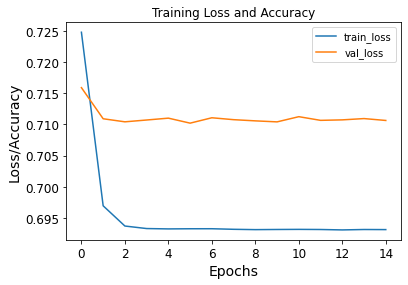

In [45]:
plot_hist(h0)

In [46]:
score = m0.evaluate(X_test, y_test)
score

58/58 [==============================] - 0s 4ms/step - loss: 0.7164 - accuracy: 0.4723


[0.7163832187652588, 0.4723321497440338]

In [47]:
h1 = m0.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

Epoch 1/15
189/189 [==============================] - 3s 13ms/step - loss: 0.5139 - accuracy: 0.6468 - val_loss: 0.4514 - val_accuracy: 0.7421
Epoch 2/15
189/189 [==============================] - 2s 12ms/step - loss: 0.4164 - accuracy: 0.7615 - val_loss: 0.4216 - val_accuracy: 0.8295
Epoch 3/15
189/189 [==============================] - 2s 13ms/step - loss: 0.3745 - accuracy: 0.8107 - val_loss: 0.3768 - val_accuracy: 0.8442
Epoch 4/15
189/189 [==============================] - 2s 12ms/step - loss: 0.3503 - accuracy: 0.8256 - val_loss: 0.3516 - val_accuracy: 0.8397
Epoch 5/15
189/189 [==============================] - 2s 12ms/step - loss: 0.3421 - accuracy: 0.8300 - val_loss: 0.3434 - val_accuracy: 0.8344
Epoch 6/15
189/189 [==============================] - 2s 12ms/step - loss: 0.3393 - accuracy: 0.8318 - val_loss: 0.3402 - val_accuracy: 0.8325
Epoch 7/15
189/189 [==============================] - 2s 12ms/step - loss: 0.3350 - accuracy: 0.8338 - val_loss: 0.3356 - val_accuracy: 0.8389

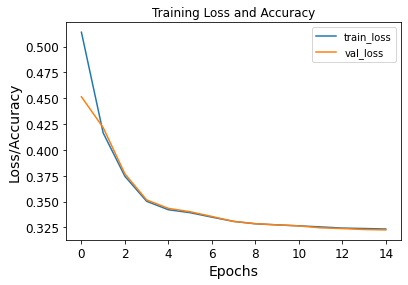

In [48]:
plot_hist(h1)

In [49]:
pred= m0.predict(X_test)

In [50]:
pred = pred.reshape(pred.shape[0],pred.shape[1], pred.shape[2])

In [51]:
pred_bool = pred >= 0.5

In [78]:
pred.shape

(1827, 48, 64)

In [99]:
import xarray as xr
def convert_xarray(x, time, lat, lon):
    """Function to convert an array into xarray
       Args:
       x: array
       d: xarray with dimentions time, lat and lon
    """
    if (len(x.shape) > 3):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
     
    if time == None:
        out = xr.DataArray(x, coords=[lat, lon],
        dims=['lat','lon'])
    else:    
        out = xr.DataArray(x, coords=[time, lat, lon],
        dims=["time",'lat','lon'])
        
    return(out)

In [100]:
def eval_matrix(mat_truth, mat_pred):
    """Store the precision and recall values for each point"""
    precision_matrix = np.zeros((mat_pred.shape[1], mat_pred.shape[2]))
    recall_matrix = np.zeros((mat_pred.shape[1], mat_pred.shape[2]))
    for ila in range(0,pred.shape[1]):
        for ilo in range(0,pred.shape[2]):
            cm=confusion_matrix(mat_truth[:,ila,ilo],mat_pred[:,ila,ilo])
            TP = cm[0,0]
            TN = cm[1,1]
            FP = cm[1,0]
            FN = cm[0,1]
            precision_matrix[ila,ilo] = TP/(TP+FP)
            recall_matrix[ila,ilo] = TP/(TP+FN)
    
    return precision_matrix, recall_matrix
    
    

In [86]:
precision1, recall1 = eval_matrix(y_test, pred_bool)

In [107]:
precision1 = convert_xarray(precision1, None, dg_test.data.lat, dg_test.data.lon)
recall1 = convert_xarray(recall1, None, dg_test.data.lat, dg_test.data.lon)

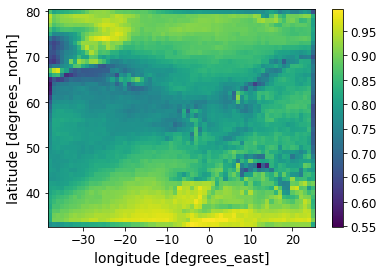

In [108]:
recall1.plot()

In [67]:
# Precision = TruePositives / (TruePositives + FalsePositives)
# Recall = TruePositives / (TruePositives + FalseNegatives)


In [ ]:
print(precision)
print(recall)

0.9941099476439791
0.8821138211382114


In [ ]:
precision_score(y_test[:,10,10],pred_bool[:,10,10],average='weighted')

0.955429504337642

In [ ]:
recall_score(y_test[:,10,10],pred_bool[:,10,10],average='weighted')

0.8839627805145046

In [118]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                           restore_best_weights = True)

In [119]:
class modCNN():
    """
      Here I test different architectures using LSTM 
      I test CNN + LSTM and convLSTM 
      args: inputs shape and type of model
    """
 
    
    def __init__(self, input_shape, model):
        
        self.input_shape = input_shape
        
        if model == "model_convlstm2d":
            self.model_convlstm2d()
        elif model == "model_conv2d_lstm":
            self.model_conv2d_lstm()
        elif model == "model_convlstm2d_v2":
            self.model_convlstm2d_v2()
        else:
            raise('The model is not defined')
            self.model_conv2d_lstm()
        
    def model_convlstm2d(self):
        #create model
        model = Sequential()

        #add model layers
        model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                                 input_shape= self.input_shape,
                                 return_sequences=True,
                                 padding = 'same',
                                 go_backwards=True,
                                 activation='tanh', recurrent_activation='hard_sigmoid',
                                 data_format = 'channels_last',
                                 kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                 dropout=0.4, recurrent_dropout=0.2
                                 ))
        model.add(BatchNormalization())

        model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                                 return_sequences=True,
                                 go_backwards=True,
                                 padding = 'same',
                                 activation='tanh', recurrent_activation='hard_sigmoid',
                                 kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                 data_format = 'channels_last',
                                 dropout=0.4, recurrent_dropout=0.2
                                 ))
        model.add(BatchNormalization())

        model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),
                                 return_sequences=False,
                                 go_backwards=True,
                                 padding = 'same',
                                 activation='tanh', recurrent_activation='hard_sigmoid',
                                 kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                 data_format = 'channels_last',
                                 dropout=0.3, recurrent_dropout=0.2
                                 ))
        model.add(BatchNormalization())
        
        model.add(Conv2D(filters=1, kernel_size=(1, 1),
                   activation='sigmoid',
                   data_format='channels_last')) 

        # loss and optimizer
        #optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        #model.compile(loss=categorical_crossentropy,
        #                optimizer=optimizer,
        #                metrics=['accuracy'])
        
        return model
        
    def model_conv2d_lstm(self):
        # this model uses CNN + LSTM
        # after the LSTM, it needs to be reshape and upscalled to keep the output shape
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Reshape((24*32, 16)))  # I need to reshape, as the LSTM expect a tensor 2D
        model.add(LSTM(units=16,return_sequences=True))
        model.add(Dense(1, activation='relu'))
        model.add(Flatten())
        model.add(Reshape((24, 32, 1)))
        model.add(Conv2DTranspose(16, (2,2),strides = 2, activation='relu', padding='same'))
        model.add(BatchNormalization())
        #model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
        #model.add(UpSampling2D((2,2)))
        model.add(Conv2D(1, (2,2), activation='sigmoid', padding='same'))
        
        
        return model
    
    
    
    
    def model_convlstm2d_v2(self):
        # This model is similar to the model_convlstm2d 
        # but it adds more layers, maxpooling and then the convtranspose 
        # to recover the original shapes
        model = Sequential()

        #add model layers
        model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                                         input_shape= self.input_shape,
                                         return_sequences=True,
                                         padding = 'same',
                                         go_backwards=True,
                                         activation='tanh', recurrent_activation='hard_sigmoid',
                                         data_format = 'channels_last',
                                         kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                         dropout=0.4, recurrent_dropout=0.2
                                         ))
        model.add(BatchNormalization())

        model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                                         return_sequences=True,
                                         go_backwards=True,
                                         padding = 'same',
                                         activation='tanh', recurrent_activation='hard_sigmoid',
                                         kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                         data_format = 'channels_last',
                                         dropout=0.4, recurrent_dropout=0.2
                                         ))
        model.add(BatchNormalization())

        model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),
                                         return_sequences=False,
                                         go_backwards=True,
                                         padding = 'same',
                                         activation='tanh', recurrent_activation='hard_sigmoid',
                                         kernel_initializer='glorot_uniform', unit_forget_bias=True, 
                                         data_format = 'channels_last',
                                         dropout=0.3, recurrent_dropout=0.2
                                         ))
        model.add(BatchNormalization())

        model.add(Conv2D(filters=16, kernel_size=(1, 1),
                           activation='relu',
                           data_format='channels_last')) 


        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
        #model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=(2, 2), 
                           activation='sigmoid',padding='same',
                           data_format='channels_last'))



        #model.add(Dense(512, activation='relu'))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.4))

        #model.add(Dense(512, activation='relu'))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.4))

        #model.add(Dense(128, activation='relu'))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.4))

        #model.add(Dense(1, activation='linear'))

        return(model)


In [120]:
(h, w, c)

(48, 64, 10)

In [121]:
model_1 = modCNN((h, w, c), "model_conv2d_lstm")
m1 = model_1.model_conv2d_lstm()

In [122]:
m1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 64, 16)        1456      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 32, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 24, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 24, 32, 16)        0         
                                                                 
 reshape_2 (Reshape)         (None, 768, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 768, 16)          

In [123]:
model_loss = weighted_binary_cross_entropy(weights = {0: 0.2, 1: 0.8})

In [124]:
# compile
m1.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#m1.compile(optimizer="adam", loss=model_loss, metrics=['accuracy'])

In [125]:
hist_m1 = m1.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                 validation_data=(X_val, y_val),
                          epochs=EPOCHS)

Epoch 1/15
189/189 [==============================] - 9s 33ms/step - loss: 0.3948 - accuracy: 0.9345 - val_loss: 0.2184 - val_accuracy: 0.9480
Epoch 2/15
189/189 [==============================] - 6s 29ms/step - loss: 0.2009 - accuracy: 0.9505 - val_loss: 0.2079 - val_accuracy: 0.9480
Epoch 3/15
189/189 [==============================] - 6s 29ms/step - loss: 0.1996 - accuracy: 0.9506 - val_loss: 0.2070 - val_accuracy: 0.9480
Epoch 4/15
189/189 [==============================] - 6s 29ms/step - loss: 0.1983 - accuracy: 0.9506 - val_loss: 0.2100 - val_accuracy: 0.9480
Epoch 5/15
189/189 [==============================] - 6s 30ms/step - loss: 0.1978 - accuracy: 0.9506 - val_loss: 0.2090 - val_accuracy: 0.9480
Epoch 6/15
189/189 [==============================] - 6s 30ms/step - loss: 0.1975 - accuracy: 0.9506 - val_loss: 0.2068 - val_accuracy: 0.9480
Epoch 7/15
189/189 [==============================] - 6s 30ms/step - loss: 0.1974 - accuracy: 0.9506 - val_loss: 0.2058 - val_accuracy: 0.9480

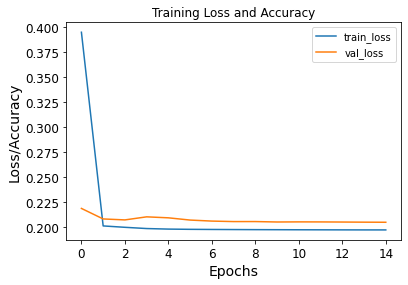

In [126]:
plot_hist(hist_m1)

In [127]:
# Note: for model the conlstm2d: The input shape must be a 5D-tensor, so one extra dimension must be added
# since I used channel last, it has to be reshape!!
model_2 = modCNN((None, 48, 64, 10), "model_convlstm2d")

In [128]:
m2 = model_2.model_convlstm2d()

In [129]:
m2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 48, 64, 32)  48512     
                                                                 
 batch_normalization_8 (Batc  (None, None, 48, 64, 32)  128      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 48, 64, 16)  27712     
                                                                 
 batch_normalization_9 (Batc  (None, None, 48, 64, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 48, 64, 8)         6944      
                                                                 
 batch_normalization_10 (Bat  (None, 48, 64, 8)       

In [130]:
m2.compile(optimizer="adam", loss=model_loss, metrics=['accuracy'])
#m2.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [131]:
# Fit the model
hist_m2 = m2.fit(XX_res_new,
                     YY_new,
                     epochs=EPOCHS,
                     batch_size= BATCH_SIZE,
                     validation_data=(XV_res_new,YV_new))

Epoch 1/15
189/189 [==============================] - 26s 90ms/step - loss: 0.1372 - accuracy: 0.8513 - val_loss: 0.1155 - val_accuracy: 0.9480
Epoch 2/15
189/189 [==============================] - 16s 84ms/step - loss: 0.1082 - accuracy: 0.9506 - val_loss: 0.1091 - val_accuracy: 0.9480
Epoch 3/15
189/189 [==============================] - 16s 84ms/step - loss: 0.1056 - accuracy: 0.9506 - val_loss: 0.1090 - val_accuracy: 0.9480
Epoch 4/15
189/189 [==============================] - 16s 84ms/step - loss: 0.1055 - accuracy: 0.9506 - val_loss: 0.1090 - val_accuracy: 0.9480
Epoch 5/15
189/189 [==============================] - 16s 84ms/step - loss: 0.1055 - accuracy: 0.9506 - val_loss: 0.1091 - val_accuracy: 0.9480
Epoch 6/15
189/189 [==============================] - 16s 85ms/step - loss: 0.1055 - accuracy: 0.9506 - val_loss: 0.1090 - val_accuracy: 0.9480
Epoch 7/15
189/189 [==============================] - 16s 85ms/step - loss: 0.1055 - accuracy: 0.9506 - val_loss: 0.1090 - val_accuracy:

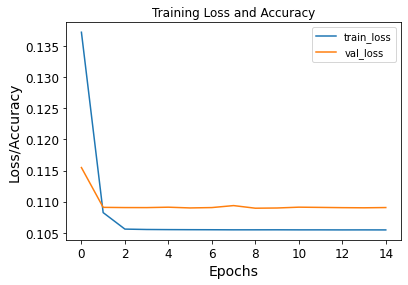

In [132]:
plot_hist(hist_m2)

In [133]:
model_3 = modCNN((None, 48, 64, 10), "model_convlstm2d_v2")

In [134]:
m3 = model_3.model_convlstm2d_v2()

In [135]:
m3.compile(optimizer="adam", loss=model_loss, metrics=['accuracy'])

In [136]:
hist_m3 = m3.fit(XX_res_new,
                     YY_new,
                     epochs=EPOCHS,
                     batch_size= BATCH_SIZE,
                     validation_data=(XV_res_new,YV_new))

Epoch 1/15
189/189 [==============================] - 27s 90ms/step - loss: 0.1514 - accuracy: 0.8995 - val_loss: 0.1400 - val_accuracy: 0.9480
Epoch 2/15
189/189 [==============================] - 16s 85ms/step - loss: 0.1350 - accuracy: 0.9472 - val_loss: 0.1315 - val_accuracy: 0.9480
Epoch 3/15
189/189 [==============================] - 16s 85ms/step - loss: 0.1271 - accuracy: 0.9503 - val_loss: 0.1260 - val_accuracy: 0.9480
Epoch 4/15
189/189 [==============================] - 16s 86ms/step - loss: 0.1217 - accuracy: 0.9506 - val_loss: 0.1216 - val_accuracy: 0.9480
Epoch 5/15
189/189 [==============================] - 16s 85ms/step - loss: 0.1176 - accuracy: 0.9506 - val_loss: 0.1182 - val_accuracy: 0.9480
Epoch 6/15
189/189 [==============================] - 16s 86ms/step - loss: 0.1143 - accuracy: 0.9506 - val_loss: 0.1155 - val_accuracy: 0.9480
Epoch 7/15
189/189 [==============================] - 16s 86ms/step - loss: 0.1119 - accuracy: 0.9506 - val_loss: 0.1135 - val_accuracy:

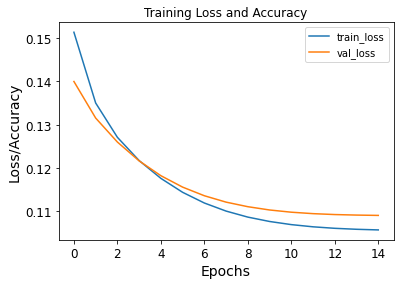

In [137]:
plot_hist(hist_m3) # seems better..but still need to be carefully evaluated

In [174]:
pred_test_m3 = m3.predict(XT_res_new)
pred_train_m3 = m3.predict(XX_res_new)

In [177]:
if (len(pred_test_m3.shape) > 3):
        xx = pred_test_m3.reshape(pred_test_m3.shape[0], pred_test_m3.shape[1], pred_test_m3.shape[2])

In [178]:
ym1_pred_test_bool = xx >=0.5
#ym1_pred_train_bool = pred_train_m1 >=0.5

In [179]:
x=confusion_matrix(y_test[:,20,10],ym1_pred_test_bool[:,20,10] )

In [141]:
# convert into xarray
d_pred_test_m1 = convert_xarray(pred_test_m1, dg_test.data.time, dg_test.data.lat, dg_test.data.lon)
d_log_test_m1 = convert_xarray(ym1_pred_test_bool, dg_test.data.time, dg_test.data.lat, dg_test.data.lon)

In [142]:
# same for train
d_pred_train_m1 = convert_xarray(pred_train_m1, dg_train.data.time, dg_train.data.lat, dg_train.data.lon)
d_log_train_m1 = convert_xarray(ym1_pred_train_bool, dg_train.data.time, dg_train.data.lat, dg_train.data.lon)